### Test trackpy

In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import tifffile as tiff
import trackpy as tp

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Load your mask array
masks = np.load('/home/nbahou/myimaging/apoDet/data/dataset1/apo_masks/Exp07_Site01.npz')['gt']
print("Masks shape:", masks.shape)  # e.g., (n_frames, height, width)

# Create an output widget for plotting
out = widgets.Output()

# Initialize the current frame index
current_frame = 0

# Function to display a given frame
def show_frame(frame_idx):
    with out:
        clear_output(wait=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(masks[frame_idx], cmap='gray')
        plt.title(f'Frame: {frame_idx}')
        plt.axis('off')
        plt.show()

# Create a slider for frame selection
slider = widgets.IntSlider(value=0, min=0, max=masks.shape[0]-1, step=1, description='Frame:')

# Function to update display when slider value changes
def on_slider_change(change):
    global current_frame
    if change['type'] == 'change' and change['name'] == 'value':
        current_frame = change['new']
        show_frame(current_frame)

slider.observe(on_slider_change)

# Button callbacks for "Previous" and "Next"
def on_prev_clicked(b):
    global current_frame
    if current_frame > 0:
        current_frame -= 1
        slider.value = current_frame  # This triggers slider observer

def on_next_clicked(b):
    global current_frame
    if current_frame < masks.shape[0] - 1:
        current_frame += 1
        slider.value = current_frame  # This triggers slider observer

# Create the buttons
prev_button = widgets.Button(description="Previous")
next_button = widgets.Button(description="Next")
prev_button.on_click(on_prev_clicked)
next_button.on_click(on_next_clicked)

# Layout: buttons and slider on one row, and the output below
controls = widgets.HBox([prev_button, slider, next_button])
display(controls, out)

# Show the initial frame
show_frame(current_frame)


Masks shape: (1930, 1024, 1024)


Output()

In [3]:
features = pd.read_csv('/home/nbahou/myimaging/apoDet/data/dataset1/summary_dfs/Exp07_Site01_pd_df.csv')
features.rename({'t': 'frame'}, inplace=True, axis=1)

features.head()

,obj_id,frame,x,y
0,1,0,552,604
1,3,0,32,890
2,4,0,966,856
3,6,0,622,984
4,7,0,576,694


In [4]:
tracked_features_list = []
for search_range in range(4,21,4):
    memory_list = []
    for memory in range(3,7):
        memory_list.append(tp.link_df(features, search_range, memory=memory, adaptive_stop=2, adaptive_step=0.95))
    tracked_features_list.append(memory_list)

Frame 1929: 1863 trajectories present.


### Visualizations without adaptive step

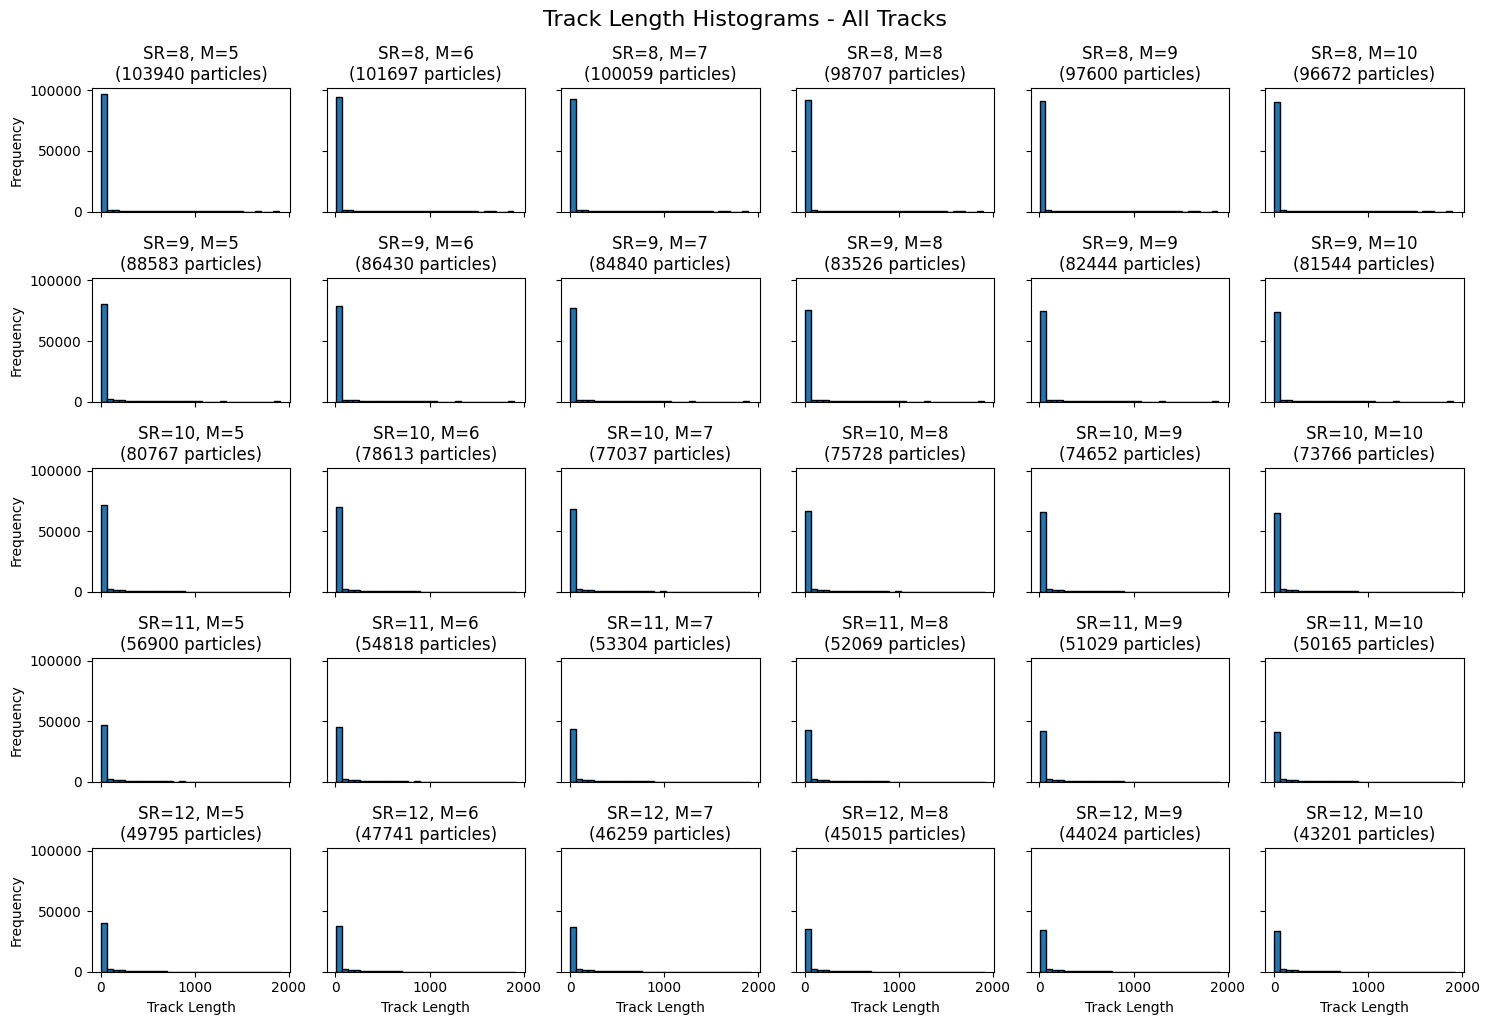

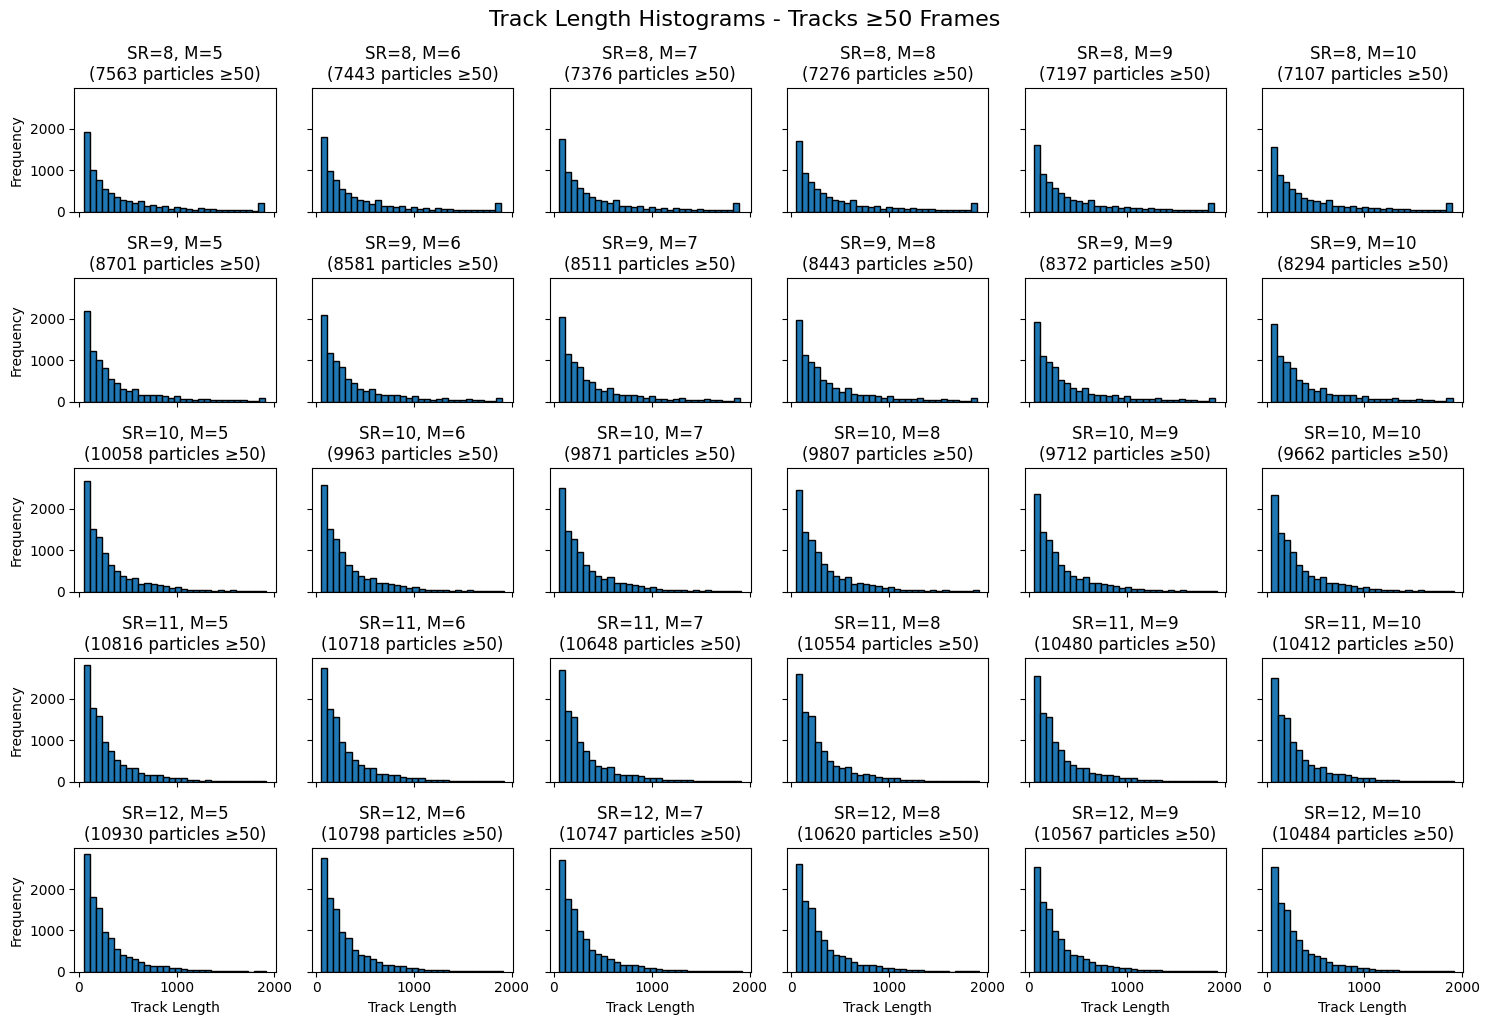

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# First version: All tracks
fig1, axes1 = plt.subplots(len(tracked_features_list), len(tracked_features_list[0]), 
                         figsize=(15, 10), sharex=True, sharey=True)

for i, memory_list in enumerate(tracked_features_list):
    search_range = i + 8
    
    for j, tracked_df in enumerate(memory_list):
        memory = j + 5
        ax = axes1[i, j]
        
        track_lengths = tracked_df.groupby('particle').size()
        particle_count = len(track_lengths)
        
        ax.hist(track_lengths, bins=30, edgecolor='black')
        ax.set_title(f'SR={search_range}, M={memory}\n({particle_count} particles)')
        
        if i == len(tracked_features_list)-1:
            ax.set_xlabel('Track Length')
        if j == 0:
            ax.set_ylabel('Frequency')

plt.tight_layout()
fig1.suptitle('Track Length Histograms - All Tracks', y=1.02, fontsize=16)

# Second version: Filtered tracks
fig2, axes2 = plt.subplots(len(tracked_features_list), len(tracked_features_list[0]), 
                         figsize=(15, 10), sharex=True, sharey=True)

min_track_length = 50

for i, memory_list in enumerate(tracked_features_list):
    search_range = i + 8
    
    for j, tracked_df in enumerate(memory_list):
        memory = j + 5
        ax = axes2[i, j]
        
        track_lengths = tracked_df.groupby('particle').size()
        filtered_track_lengths = track_lengths[track_lengths >= min_track_length]
        particle_count = len(filtered_track_lengths)
        
        ax.hist(filtered_track_lengths, bins=30, edgecolor='black')
        ax.set_title(f'SR={search_range}, M={memory}\n({particle_count} particles ≥{min_track_length})')
        
        if i == len(tracked_features_list)-1:
            ax.set_xlabel('Track Length')
        if j == 0:
            ax.set_ylabel('Frequency')

plt.tight_layout()
fig2.suptitle(f'Track Length Histograms - Tracks ≥{min_track_length} Frames', y=1.02, fontsize=16)

plt.show()

### Visualizations with adaptive step

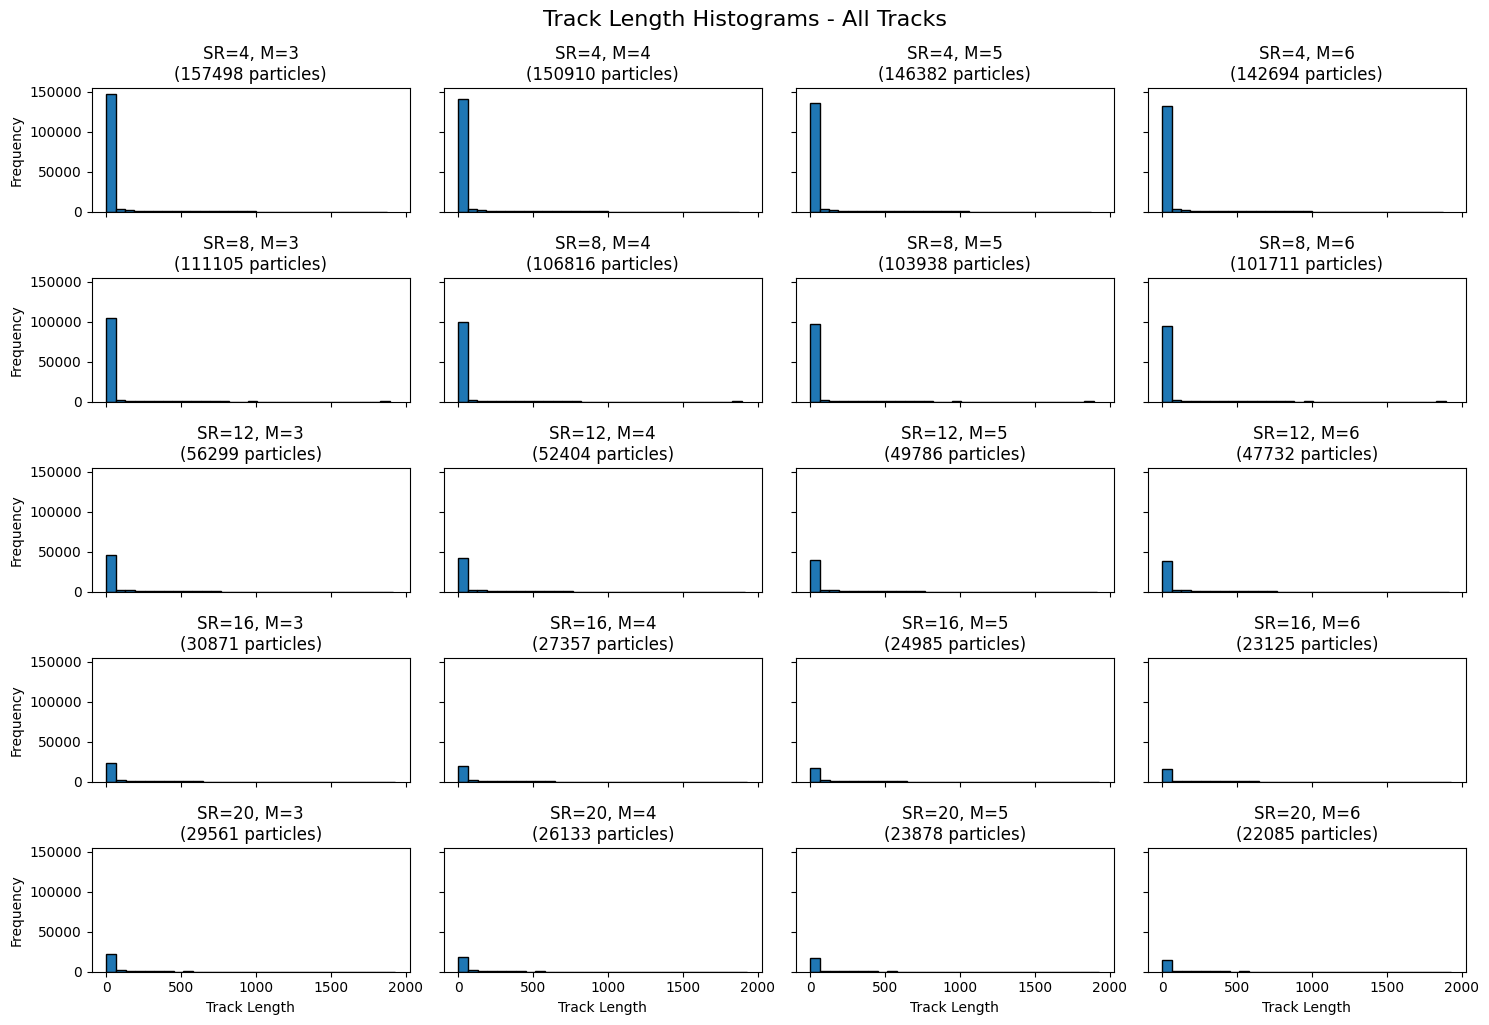

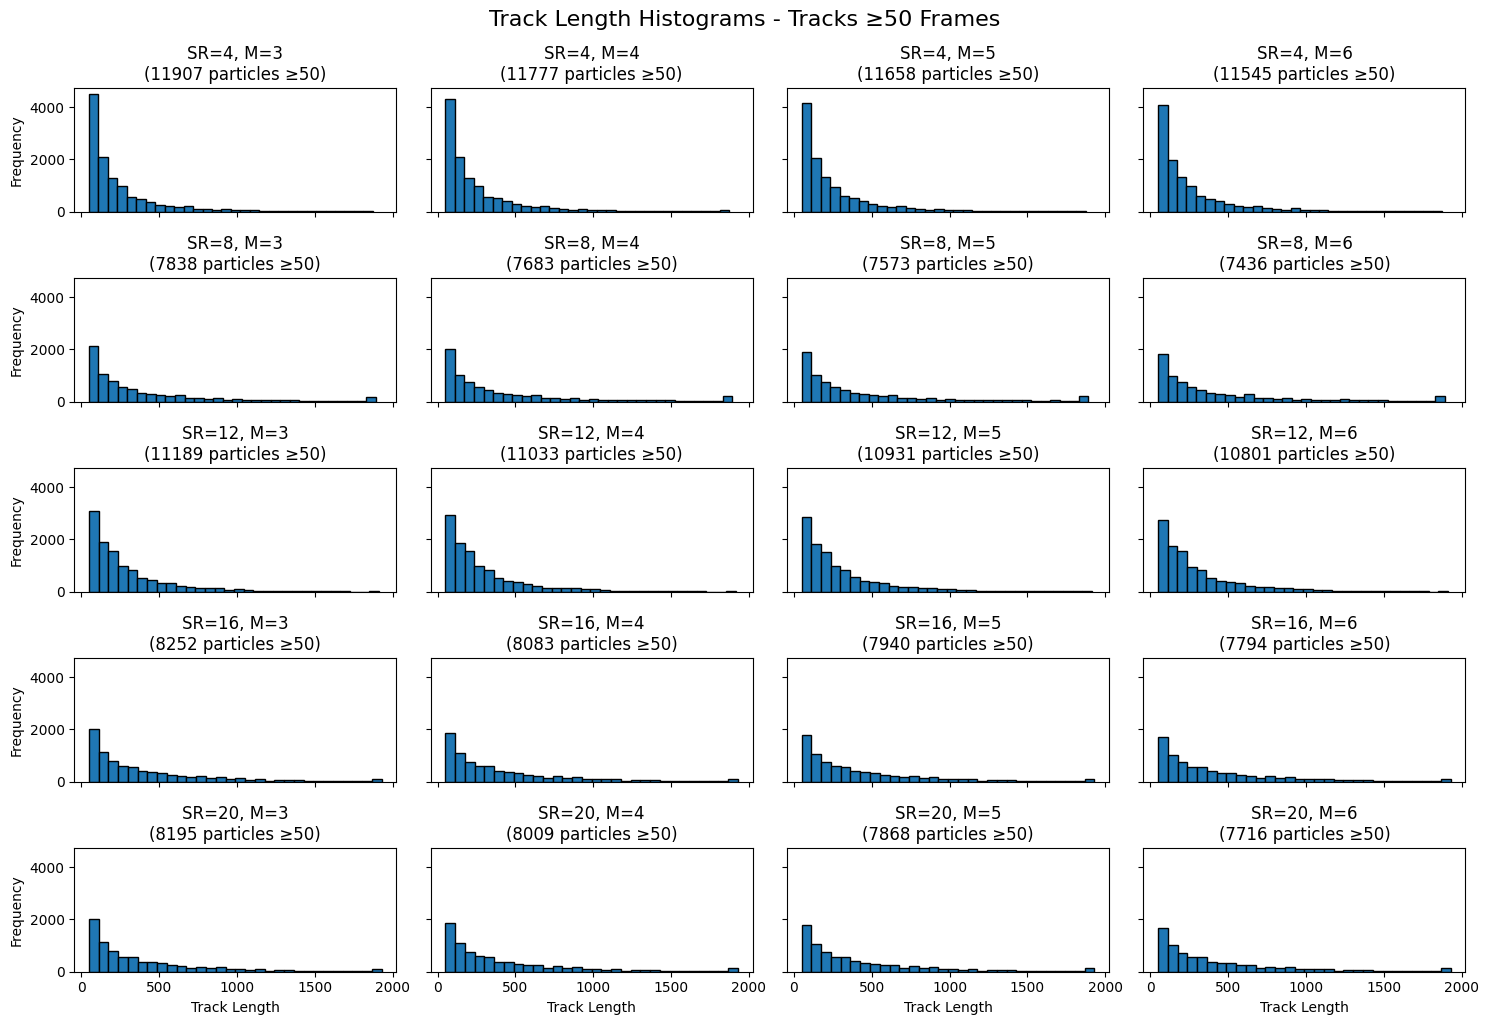

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# For all tracks
fig1, axes1 = plt.subplots(len(tracked_features_list), len(tracked_features_list[0]), 
                         figsize=(15, 10), sharex=True, sharey=True)

for i, memory_list in enumerate(tracked_features_list):
    search_range = (i * 4) + 4  # 4, 8, 12, 16, 20
    
    for j, tracked_df in enumerate(memory_list):
        memory = j + 3  # 3, 4, 5, 6
        ax = axes1[i, j]
        
        track_lengths = tracked_df.groupby('particle').size()
        particle_count = len(track_lengths)
        
        ax.hist(track_lengths, bins=30, edgecolor='black')
        ax.set_title(f'SR={search_range}, M={memory}\n({particle_count} particles)')
        
        if i == len(tracked_features_list)-1:
            ax.set_xlabel('Track Length')
        if j == 0:
            ax.set_ylabel('Frequency')

plt.tight_layout()
fig1.suptitle('Track Length Histograms - All Tracks', y=1.02, fontsize=16)

# For filtered tracks
fig2, axes2 = plt.subplots(len(tracked_features_list), len(tracked_features_list[0]), 
                         figsize=(15, 10), sharex=True, sharey=True)

min_track_length = 50

for i, memory_list in enumerate(tracked_features_list):
    search_range = (i * 4) + 4
    
    for j, tracked_df in enumerate(memory_list):
        memory = j + 3
        ax = axes2[i, j]
        
        track_lengths = tracked_df.groupby('particle').size()
        filtered_track_lengths = track_lengths[track_lengths >= min_track_length]
        particle_count = len(filtered_track_lengths)
        
        ax.hist(filtered_track_lengths, bins=30, edgecolor='black')
        ax.set_title(f'SR={search_range}, M={memory}\n({particle_count} particles ≥{min_track_length})')
        
        if i == len(tracked_features_list)-1:
            ax.set_xlabel('Track Length')
        if j == 0:
            ax.set_ylabel('Frequency')

plt.tight_layout()
fig2.suptitle(f'Track Length Histograms - Tracks ≥{min_track_length} Frames', y=1.02, fontsize=16)

plt.show()

### Old stuff

In [6]:
tracked_features = tp.link_df(features, 12, memory=7)

Frame 1929: 1863 trajectories present.


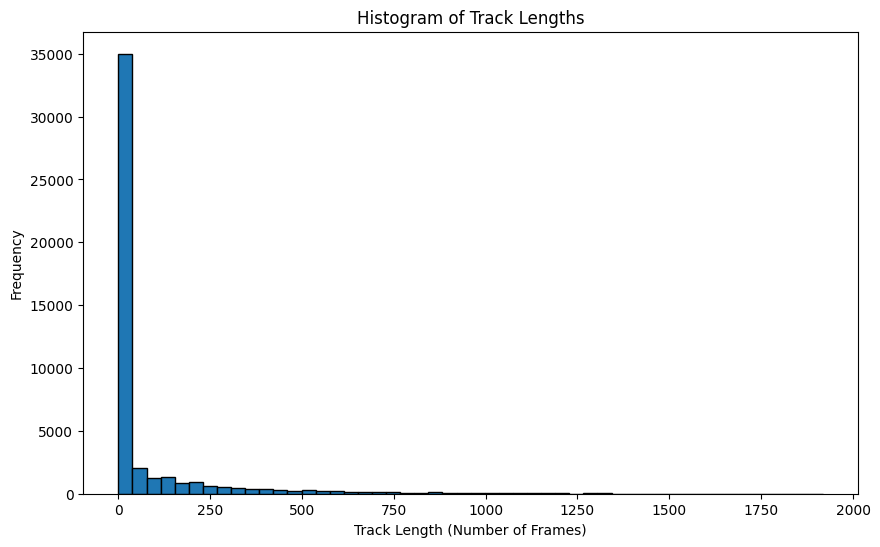

In [7]:
# Assuming your DataFrame is named df
# Compute track lengths: count the number of rows per particle

## max disp = 12
track_lengths = tracked_features.groupby('particle').size()

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=50, edgecolor='black')
plt.xlabel('Track Length (Number of Frames)')
plt.ylabel('Frequency')
plt.title('Histogram of Track Lengths')
plt.show()

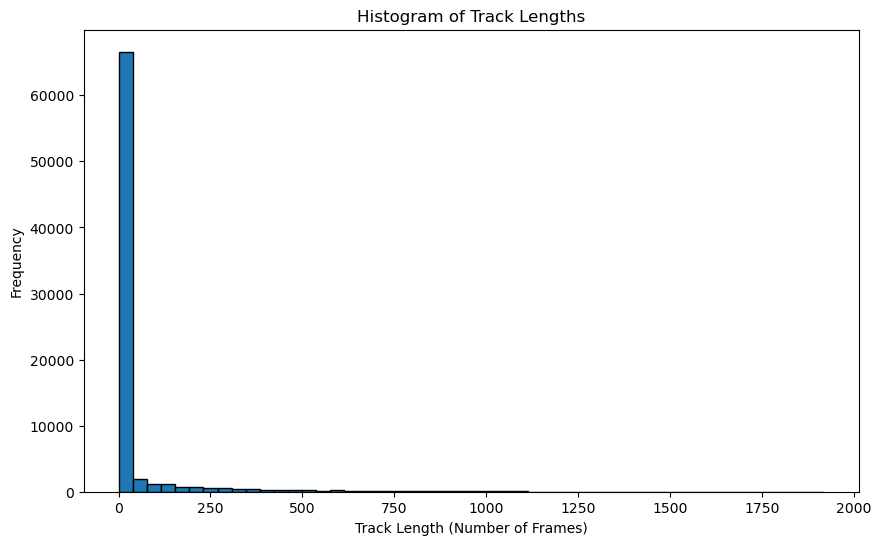

In [27]:
# Assuming your DataFrame is named df
# Compute track lengths: count the number of rows per particle

## max disp = 10
track_lengths = tracked_features.groupby('particle').size()

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=50, edgecolor='black')
plt.xlabel('Track Length (Number of Frames)')
plt.ylabel('Frequency')
plt.title('Histogram of Track Lengths')
plt.show()

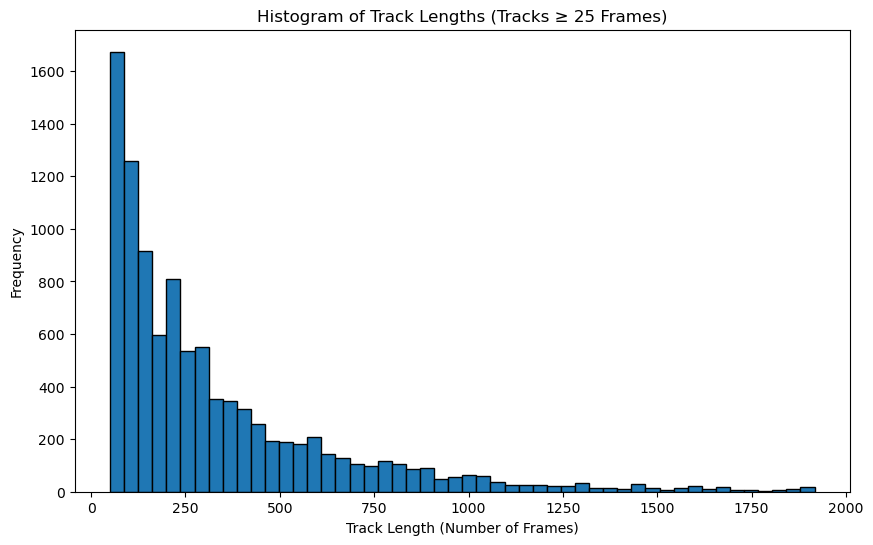

In [32]:
# Filter out tracks shorter than 25 frames
filtered_track_lengths = track_lengths[track_lengths >= 50]

# Plot the histogram of the filtered track lengths
plt.figure(figsize=(10, 6))
plt.hist(filtered_track_lengths, bins=50, edgecolor='black')
plt.xlabel('Track Length (Number of Frames)')
plt.ylabel('Frequency')
plt.title('Histogram of Track Lengths (Tracks ≥ 25 Frames)')
plt.show()

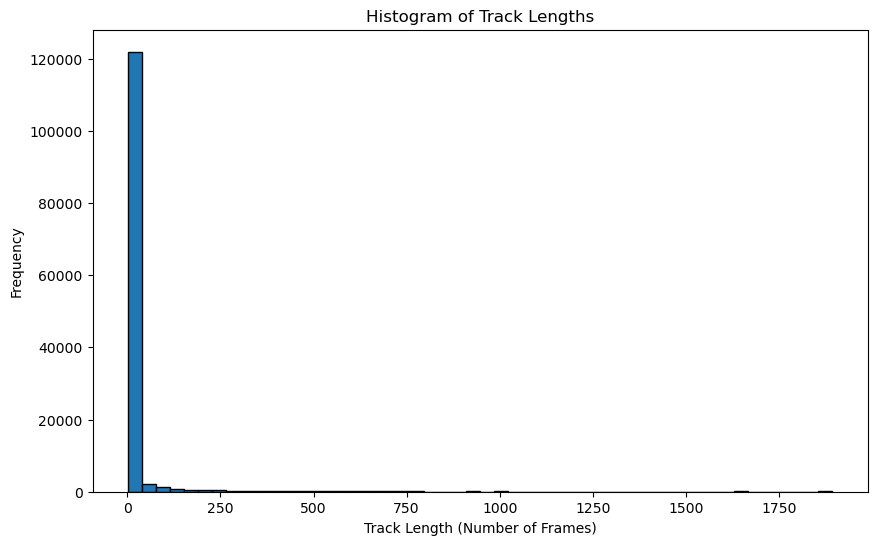

In [15]:
# Assuming your DataFrame is named df
# Compute track lengths: count the number of rows per particle
track_lengths = tracked_features.groupby('particle').size()

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(track_lengths, bins=50, edgecolor='black')
plt.xlabel('Track Length (Number of Frames)')
plt.ylabel('Frequency')
plt.title('Histogram of Track Lengths')
plt.show()

In [31]:
# Filter out particles with fewer than 25 frames and get the valid particle IDs
valid_particles = track_lengths[track_lengths >= 50].index

# Create a filtered DataFrame containing only these valid particles
filtered_df = tracked_features[tracked_features['particle'].isin(valid_particles)]

filtered_df

,obj_id,frame,x,y,particle
0,1,0,552,604,0
1123,1418,0,1004,112,2
1121,1416,0,980,812,4
1120,1415,0,630,420,5
1119,1414,0,58,1002,6
...,...,...,...,...,...
3453731,739,1929,828,796,69131
3453730,737,1929,516,376,29281
3453729,736,1929,842,738,45159
3453740,748,1929,602,554,49181


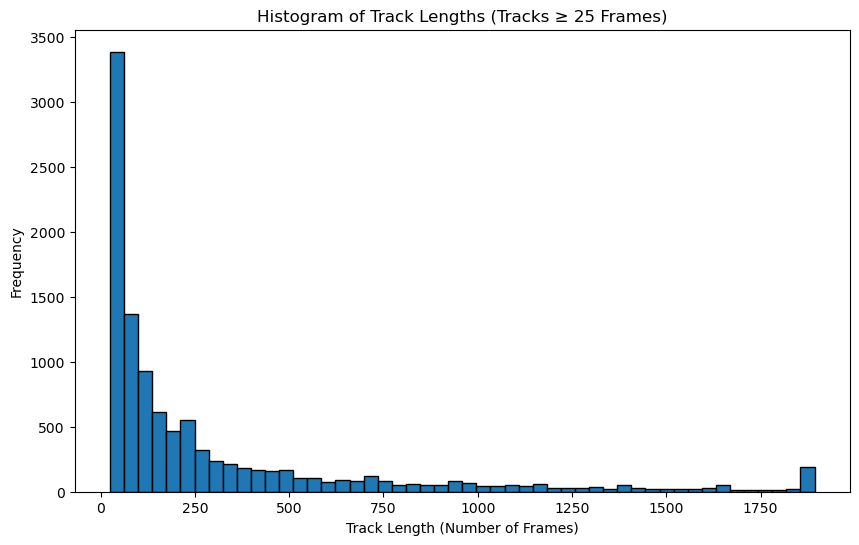

In [16]:
# Filter out tracks shorter than 25 frames
filtered_track_lengths = track_lengths[track_lengths >= 25]

# Plot the histogram of the filtered track lengths
plt.figure(figsize=(10, 6))
plt.hist(filtered_track_lengths, bins=50, edgecolor='black')
plt.xlabel('Track Length (Number of Frames)')
plt.ylabel('Frequency')
plt.title('Histogram of Track Lengths (Tracks ≥ 25 Frames)')
plt.show()

In [19]:
# Filter out particles with fewer than 25 frames and get the valid particle IDs
valid_particles = track_lengths[track_lengths >= 25].index

# Create a filtered DataFrame containing only these valid particles
filtered_df = tracked_features[tracked_features['particle'].isin(valid_particles)]

filtered_df

,obj_id,frame,x,y,particle
0,1,0,552,604,0
1124,1419,0,710,664,1
1123,1418,0,1004,112,2
1122,1417,0,750,190,3
1121,1416,0,980,812,4
...,...,...,...,...,...
3453730,737,1929,516,376,74738
3453729,736,1929,842,738,1350
3453728,735,1929,526,540,65093
3453740,748,1929,602,554,1550


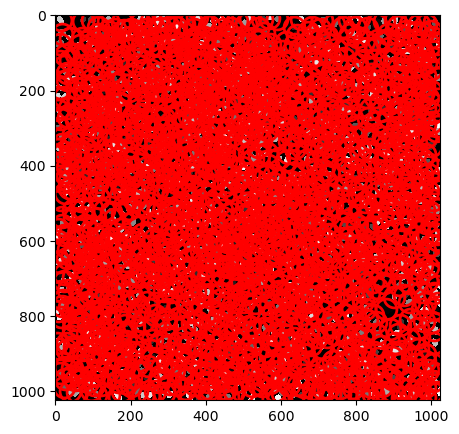

<Axes: >

In [29]:
tp.annotate(tracked_features[tracked_features['frame'] == 0], masks[0])

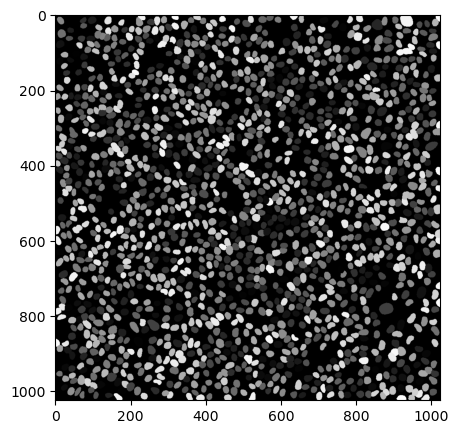

In [9]:
plt.imshow(masks[1])

In [38]:
f = tp.locate(masks[0], 15)

In [39]:
f.head()

,y,x,mass,size,ecc,signal,raw_mass,ep
0,9.483978,718.082474,31834.370480,4.424789,0.245431,434.809032,110776.0,0.0
1,6.809440,235.036927,46596.912466,3.801788,0.165327,892.569748,209646.0,0.0
2,7.503715,381.527017,56208.074501,4.014141,0.120329,846.762817,220018.0,0.0
3,8.816463,566.266582,56644.735098,4.323540,0.255849,824.235450,229782.0,0.0
4,15.272051,177.544176,41231.426098,4.363266,0.035470,552.267647,122640.0,0.0


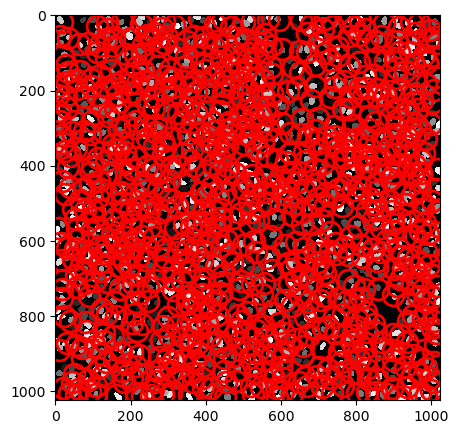

<Axes: >

In [40]:
tp.annotate(f, masks[0])

[Text(0.5, 0, 'mass'), Text(0, 0.5, 'count')]

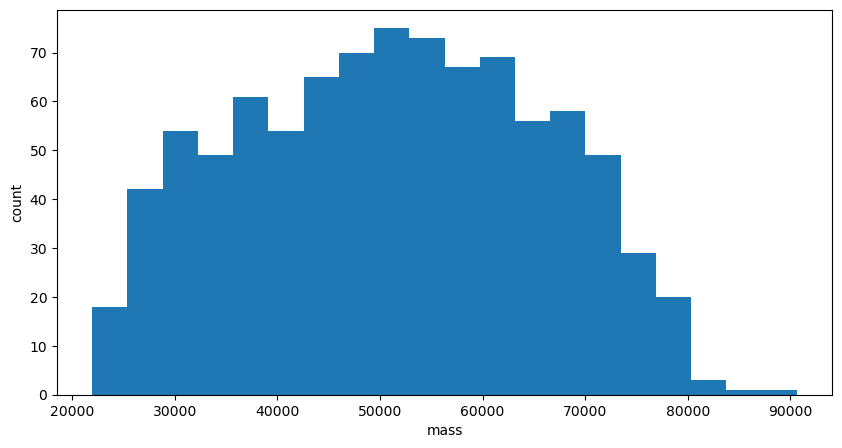

In [41]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

# Optionally, label the axes.
ax.set(xlabel='mass', ylabel='count')

/home/nbahou/miniforge3/envs/ERK_nuclei/lib/python3.10/site-packages/trackpy/plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

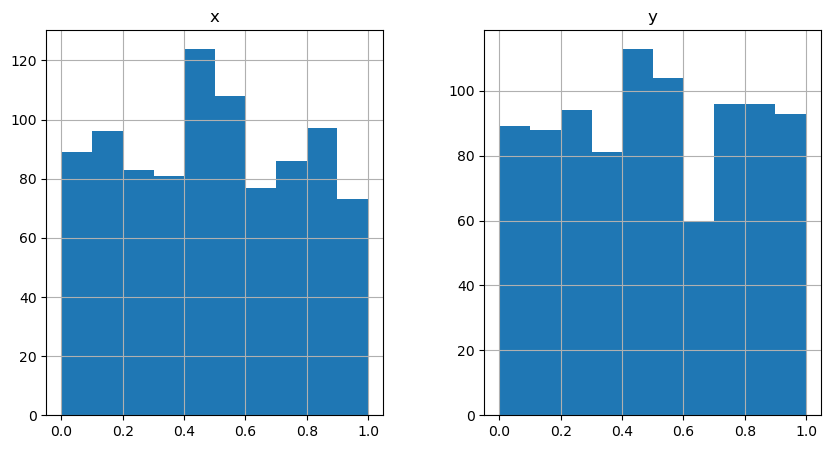

In [42]:
tp.subpx_bias(f)

In [43]:
f = tp.batch(masks[:], 13, minmass=20, invert=True)

Frame 1929: 1457 features


In [44]:
t = tp.link(f, 5, memory=3)

Frame 1929: 1457 trajectories present.


In [45]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,6.594024,279.445347,25674.503800,3.437104,0.469119,840.502935,7297590.0,-1.533918,0,0
958,677.545995,825.581411,11084.606794,3.361024,0.137578,300.610671,7380095.0,0.340507,0,1
957,679.131116,449.955806,16436.601851,3.754661,0.554816,366.849347,7366288.0,0.428040,0,2
956,675.036543,1002.103842,26654.643921,3.421141,0.107167,766.367986,7358682.0,0.498655,0,3
955,675.658985,964.302966,49559.254107,3.539895,0.143959,979.812814,7324392.0,1.945974,0,4


In [46]:
t1 = tp.filter_stubs(t, 25)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 382211
After: 25360


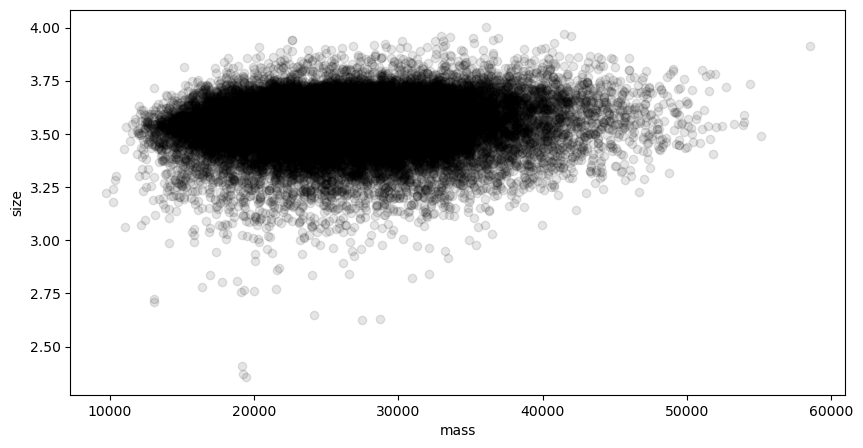

In [47]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean()); # convenience function -- just plots size vs. mass

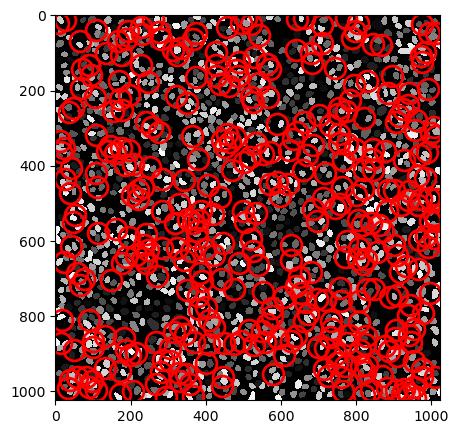

In [48]:
plt.figure()
tp.annotate(t1[t1['frame'] == 0], masks[0]);

In [52]:
t2 = t1[((t1['mass'] > 50) & (t1['size'] < 3.75) &
         (t1['ecc'] < 0.3))]

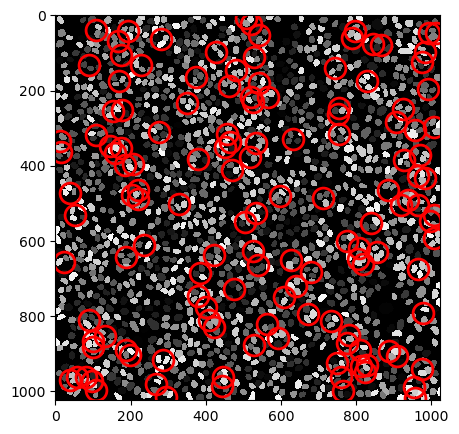

In [53]:
plt.figure()
tp.annotate(t2[t2['frame'] == 0], masks[0]);

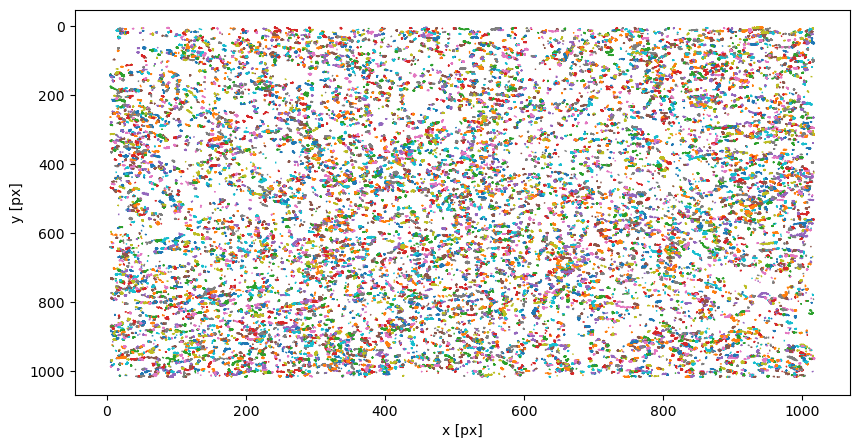

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [54]:
plt.figure()
tp.plot_traj(t2)

In [31]:
tp.locate?

Signature:
tp.locate(
    raw_image,
    diameter,
    minmass=None,
    maxsize=None,
    separation=None,
    noise_size=1,
    smoothing_size=None,
    threshold=None,
    invert=False,
    percentile=64,
    topn=None,
    preprocess=True,
    max_iterations=10,
    filter_before=None,
    filter_after=None,
    characterize=True,
    engine='auto',
)
Docstring:
Locate Gaussian-like blobs of some approximate size in an image.

Preprocess the image by performing a band pass and a threshold.
Locate all peaks of brightness, characterize the neighborhoods of the peaks
and take only those with given total brightness ("mass"). Finally,
refine the positions of each peak.

Parameters
----------
raw_image : array (any dimensions)
    Image used for final characterization. Ideally, pixel values of
    this image are not rescaled, but it can also be identical to
    ``image``.
image : array (same size as raw_image)
    Processed image used for centroid-finding and most particle
    measuremen